In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import u_momentum, v_momentum, get_rhs, get_coeff_mat, pressure_correct, update_velocity, check_divergence_free

imax = 20                        # grid size in x-direction
jmax = 20                        # grid size in y-direction
max_iteration = 6000             # iterations
max_res = 1000                   # initial residual
rho = 1                          # density
velocity = 1                     # velocity = lid velocity
mu = 0.01                        # kinematic viscosity = 1/Reynolds number
dx = 1 / (imax - 1)              # dx, dy cell sizes along x and y directions
dy = 1 / (jmax - 1)
x = np.arange(dx / 2, 1 + dx/2 - dx / 2, dx)
y = np.arange(0, 1+dy/2, dy)
alpha_p = 0.1                    # pressure under-relaxation
alpha_u = 0.7                    # velocity under-relaxation
tol = 1e-5                       # tolerance for convergence

In [2]:
# Variable declaration
p = np.zeros((imax, jmax))             # p = Pressure
p_star = np.zeros((imax, jmax))        # intermediate pressure
p_prime = np.zeros((imax, jmax))       # pressure correction
rhsp = np.zeros((imax, jmax))          # right hand side vector of pressure correction equation
div = np.zeros((imax, jmax))

# Vertical velocity
v_star = np.zeros((imax, jmax + 1))    # intermediate velocity
v = np.zeros((imax, jmax + 1))         # final velocity
d_v = np.zeros((imax, jmax + 1))       # velocity correction coefficient

# Horizontal Velocity
u_star = np.zeros((imax + 1, jmax))    # intermediate velocity
u = np.zeros((imax + 1, jmax))         # final velocity
d_u = np.zeros((imax + 1, jmax))       # velocity correction coefficient

# Boundary condition
# Lid velocity (Top wall is moving with 1m/s)
u_star[:, jmax-1] = velocity
u[:, jmax-1] = velocity

### Main Algorithm

In [3]:
res_hist = []

iteration = 1
while iteration <= max_iteration and max_res > tol:
    iteration += 1
    
    # Solve u and v momentum equations for intermediate velocity 
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)

    u_old = u.copy()
    v_old = v.copy()

    # Calculate rhs vector of the Pressure Poisson matrix 
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    
    # Form the Pressure Poisson coefficient matrix 
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)
    
    # Solve pressure correction implicitly and update pressure
    p, p_prime = pressure_correct(imax, jmax, rhsp, Ap, p_star, alpha_p)
    
    # Update velocity based on pressure correction
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
    
    # Check if velocity field is divergence free
    div = check_divergence_free(imax, jmax, dx, dy, u, v)

    p_star = p.copy()              # use p as p_star for the next iteration

    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist.append(max_res)

    # Check for convergence 
    if (iteration % 50) == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")
    
    if max_res > 2:
        print("not going to converge!")
        break

Iteration = 50; Residual = 0.002057708518317991
Iteration = 100; Residual = 0.00042560507367519346
Iteration = 150; Residual = 0.00011467008401043303
Iteration = 200; Residual = 3.196076493144906e-05


### Visualization

Final Iteration = 246; Residual = 9.846781851119424e-06


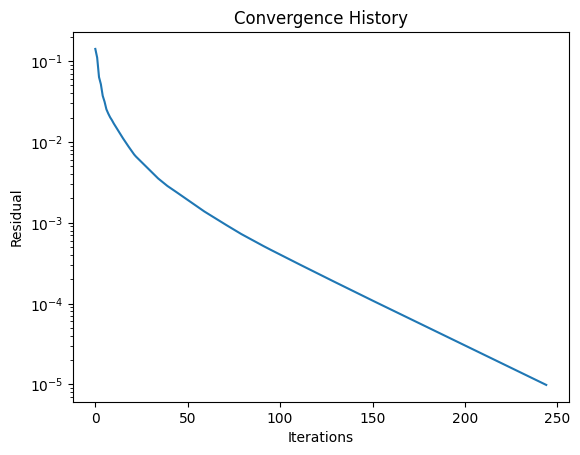

In [4]:
# Final residual        
print(f"Final Iteration = {iteration}; Residual = {max_res}")
plt.plot(np.arange(iteration)[0:-1], res_hist)
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.title("Convergence History")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

Ap Matrix Condition Number =  12653.1418575536


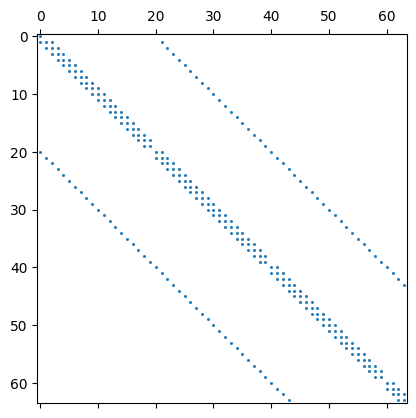

In [14]:
# Check sparse pattern
print("Ap Matrix Condition Number = ", np.linalg.cond(Ap))
plt.spy(Ap[0:64, 0:64], markersize=1)
plt.show()

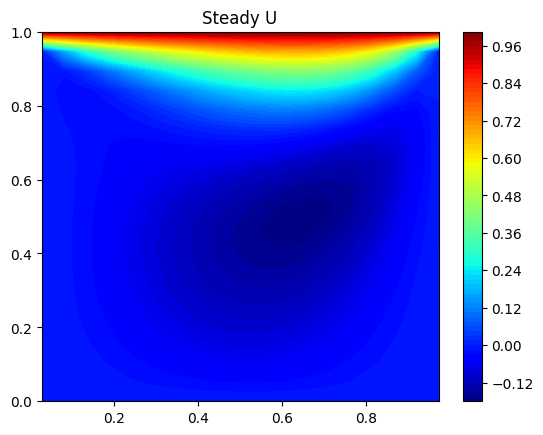

In [15]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 100, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('Steady U')
plt.show()

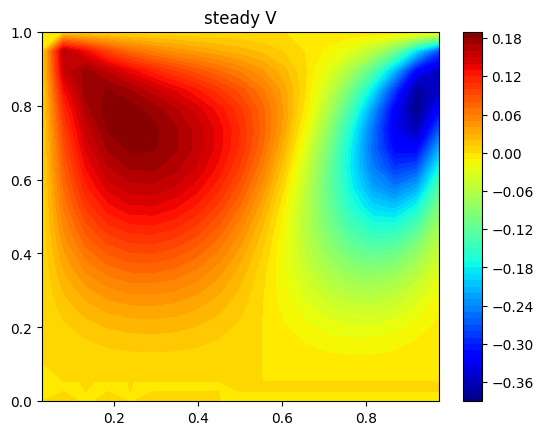

In [16]:
plt.figure()
plt.contourf(X, Y, v[0:imax-1, 0:jmax].T, 60, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('steady V')
plt.show()

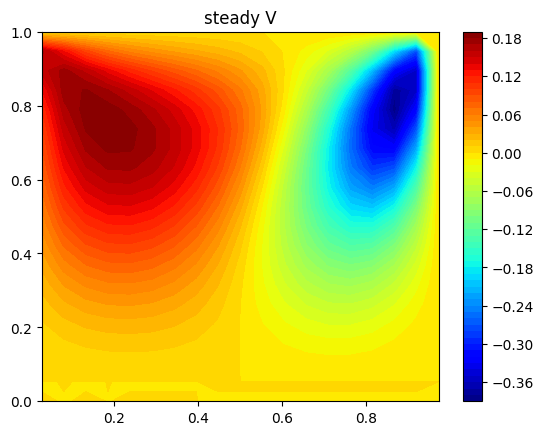

In [17]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, v[1:imax, 0:jmax].T, 60, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('steady V')
plt.show()

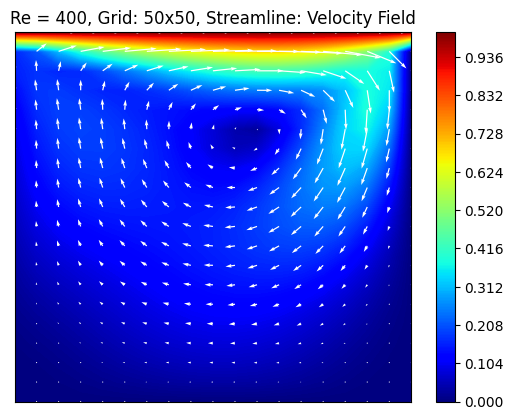

In [18]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 300, cmap='jet')
# plt.contour(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 10)
# plt.streamplot(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, density=4, linewidth=0.5, arrowsize=0.4, color='w')
plt.colorbar()
plt.quiver(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, color='w')
# plt.axis([0, 1, 0, 1])
plt.title('Re = 400, Grid: 50x50, Streamline: Velocity Field')
plt.xticks([])
plt.yticks([])
# plt.savefig("Stream_Re400_Grid50x50", dpi=500)
plt.show()

/Users/jacksong/opt/anaconda3/envs/QCFD_env/lib/python3.8/site-packages/matplotlib/patches.py:3331: RuntimeWarning: invalid value encountered in scalar divide
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


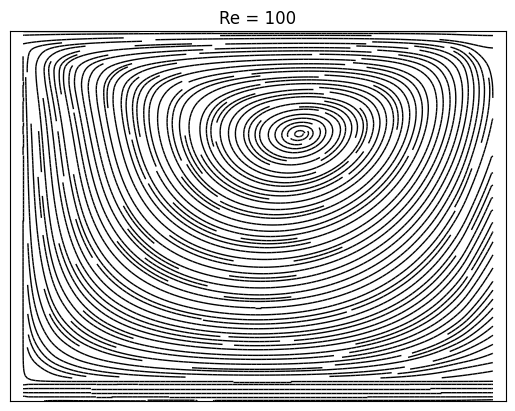

In [19]:
plt.figure()
X, Y = np.meshgrid(x, y)
# plt.contour(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 20, cmap='jet')
# plt.contour(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 10)
plt.streamplot(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, density=3, linewidth=1, arrowsize=0., color='k')
# plt.colorbar()
plt.axis([0, 1, 0, 1])
plt.title('Re = 100')
plt.xticks([])
plt.yticks([])
plt.show()

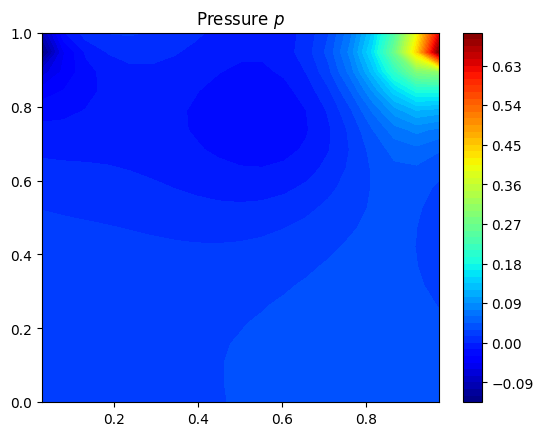

In [9]:
plt.figure()
plt.contourf(X, Y, p[1:imax, 0:jmax+1].T, 60, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('Pressure $p$')
plt.show()

### Benchmark with literature data

Ghia, U. K. N. G., Kirti N. Ghia, and C. T. Shin. "High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method." Journal of computational physics 48.3 (1982): 387-411.